#### Basic setup

In [153]:
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.feature_extraction import DictVectorizer
import sklearn.metrics
from sklearn.linear_model import LogisticRegression



In [154]:
data = wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")

#### Data prep

In [155]:
df = pd.read_csv(data)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [156]:
df.card = (df.card == 'yes').astype(int)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,1,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,1,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,1,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [157]:
# df_train, testval = sklearn.model_selection.train_test_split(df, train_size=0.6, random_state=1)
# df_val, df_test = sklearn.model_selection.train_test_split(testval, train_size=0.5, random_state=1)

df_full_train, df_test = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = sklearn.model_selection.train_test_split(df, test_size=0.25, random_state=1)

y_train = df_train['card']
y_val = df_val['card']
y_test = df_test['card']

del df_train['card']
del df_val['card']
del df_test['card']

#### Q1

In [158]:
cols = ['reports', 'dependents', 'active', 'share']
scores = {}

for col in cols:
    score = sklearn.metrics.roc_auc_score(y_train, df_train[col])
    if score < 0.5:
        score = sklearn.metrics.roc_auc_score(y_train, -df_train[col])
        scores[col] = score
    else:
        scores[col] = score

scores

{'reports': 0.7145745798319328,
 'dependents': 0.5247724089635855,
 'active': 0.5950834500466853,
 'share': 0.9883199112978523}

#### Model

In [159]:
dv = DictVectorizer(sparse=False)
traind = df_train.to_dict(orient='records')
x_train = dv.fit_transform(traind)

vald = df_val.to_dict(orient='records')
x_val = dv.transform(vald)

In [160]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

#### Q2

In [161]:
y_pred = model.predict_proba(x_val)[:, 1]
sklearn.metrics.roc_auc_score(y_val, y_pred).round(3)

0.997

#### Q3

In [162]:
scores = []
thresholds = np.linspace(0, 1, 101)
actual_positive = (y_val==1)
actual_negative = (y_val==0)


for i in thresholds:
    predict_pos = (y_pred >= i)
    predict_neg = (y_pred < i)

    tp = (predict_pos & actual_positive).sum()
    tn = (predict_neg & actual_negative).sum()
    fp = (predict_pos & actual_negative).sum()
    fn = (predict_neg & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    scores.append((i, p, r))



In [163]:
columns = ['threshold', 'precision', 'recall']
scores_df = pd.DataFrame(scores, columns=columns)

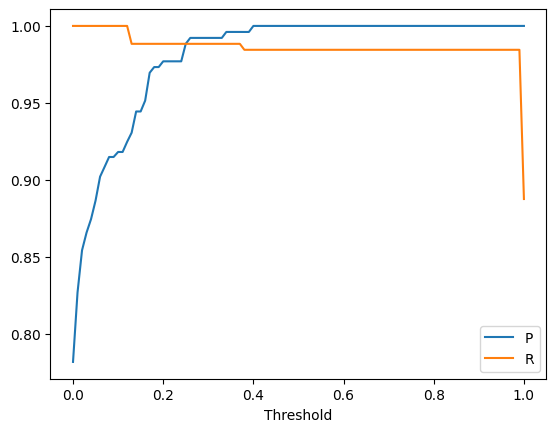

In [164]:
plt.plot(scores_df['threshold'], scores_df['precision'], label='P')
plt.plot(scores_df['threshold'], scores_df['recall'], label='R')

plt.xlabel("Threshold")
plt.legend()
plt.show()

#### Q4

In [165]:
f1_scores = []

for i in thresholds:
    predict_pos = (y_pred >= i)
    predict_neg = (y_pred < i)

    tp = (predict_pos & actual_positive).sum()
    tn = (predict_neg & actual_negative).sum()
    fp = (predict_pos & actual_negative).sum()
    fn = (predict_neg & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    f1 = 2 * p * r / (p + r)
    f1_scores.append((i, p, r, f1))



In [166]:
f1_columns = ['threshold', 'precision', 'recall', 'f1_score']
scores_df = pd.DataFrame(f1_scores, columns=f1_columns)

In [167]:
scores_df.sort_values('f1_score', ascending=False)[:10]

,threshold,precision,recall,f1_score
37,0.37,0.996094,0.988372,0.992218
34,0.34,0.996094,0.988372,0.992218
35,0.35,0.996094,0.988372,0.992218
36,0.36,0.996094,0.988372,0.992218
69,0.69,1.000000,0.984496,0.992188
67,0.67,1.000000,0.984496,0.992188
66,0.66,1.000000,0.984496,0.992188
65,0.65,1.000000,0.984496,0.992188
64,0.64,1.000000,0.984496,0.992188
63,0.63,1.000000,0.984496,0.992188


#### Q5

In [172]:
def model_train(df_train, y_train, C=1.0):
    dv = DictVectorizer(sparse=False)
    traind = df_train.to_dict(orient='records')
    x_train = dv.fit_transform(traind)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(x_train, y_train)

    return dv, model

def predict(df, dv, model):    
    dicts = df.to_dict(orient='records')
    x = dv.transform(dicts)

    y_pred = model.predict_proba(x)[:, 1]

    return y_pred

In [173]:
kfold = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=1)
kfold_scores = []

for train, val in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train]
    df_val = df_full_train.iloc[val]
    y_train = df_train.card
    y_val = df_val.card
    del df_train['card']
    del df_val['card']


    
    dv, model = model_train(df_train, y_train)    
    y_pred = predict(df_val, dv, model)
    
    auc = sklearn.metrics.roc_auc_score(y_val, y_pred)
    kfold_scores.append(auc)

np.std(kfold_scores).round(3)

0.003

#### Q6

In [175]:
c_vals = [0.01, 0.1, 1, 10]
scores_means = []

for c in c_vals:
    c_scores = []

    for train, val in kfold.split(df_full_train):

        df_train = df_full_train.iloc[train]
        df_val = df_full_train.iloc[val]
        y_train = df_train.card
        y_val = df_val.card
        del df_train['card']
        del df_val['card']

        dv, model = model_train(df_train, y_train, C=c)    
        y_pred = predict(df_val, dv, model)

        auc = sklearn.metrics.roc_auc_score(y_val, y_pred)
        c_scores.append(auc)
    scores_means.append((c, np.mean(c_scores), np.std(c_scores)))

In [179]:
columns = ['C', 'Mean', 'Std']
scores_means_df = pd.DataFrame(scores_means, columns=columns)

scores_means_df.sort_values('Mean', ascending=False)

,C,Mean,Std
2,1.00,0.996450,0.002743
3,10.00,0.996389,0.002815
1,0.10,0.995056,0.003954
0,0.01,0.991881,0.005599
